# Event Fitting

* There is a concern that one of the sensors may be depicting an event.
* An event is detected by the presence of a sigmoid curve in the trend data, as it is the cause of a binding and growth event, followed by a saturation.
* To detect this, we need to fit a sigmoid to a data set.

In [3]:
import numpy as np
import pandas as pd
import src.dataIO as io
import src.filepaths as fp
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

root = Path().absolute()
storage = Path('K://Josh/Argus_Project')

site_data = Path(f'{storage}/Site_Data/Sensor_Data')
out_path = Path(f'{storage}/Site_Data/Sensor_Figures')

* Read in the data files from the site data directory, but we are going to target specific sensors.

In [4]:
data_files = fp.extractfile(
    directory_path=site_data,
    file_string='.csv')

print(data_files)

t_0 = '11/06/2024 06:00'
t_0_object = io.parse_date(date_string=t_0)
t0 = io.convert_datetime(date_time=t_0_object)

['AmineOxide_Data_240717.csv', 'FFR_Data_240618.csv', 'FFR_Data_240702.csv', 'FFR_Data_240708.csv', 'FFR_Data_240715.csv', 'Hoyer_Data_240708.csv', 'Hoyer_Data_240715.csv', 'L300_Data_240625.csv', 'L300_Data_240702.csv', 'L300_Data_240715.csv', 'Libra_Data1_240625.csv', 'Libra_Data2_240625.csv', 'Libra_Data_240618.csv', 'Libra_Data_240715.csv']


* Now target the specific headers that we want to find.

In [5]:
headers = {
    'Amine_Oxide_Flow_Sensor_1': [[], []],
    'Amine_Oxide_Flow_Sensor_2': [[], []],
    'Amine_Oxide_Flow_Temp_1': [[], []],
    'Amine_Oxide_Flow_Temp_2': [[], []]
}

header_keys = [key for key, value in headers.items()]

for file in data_files:
    file_path = Path(f'{site_data}/{file}')
    data = pd.read_csv(filepath_or_buffer=file_path, sep=',')
    data_headers = list(data)
    
    for header in data_headers:
        if header in header_keys:
            headers[header][0].extend(data['timestamp'].tolist())
            headers[header][1].extend(data[header].tolist())

* That has now appended the time stamp data and the sensor data to a list stored in a dictionary where the keys are the sensor names.
* Really, this is how I should have managed it before, and as I work on this, I will improve the formatting as such.
* It's all still a work-in-progress sort of thing.
* Now we need to define a sigmoid equation.
* A sigmoid function is a mathematical function that produces an "S"-shaped curve.
* The equation is given as:

$$S(x)=\frac{1}{1+e^{-x}}$$

* So let's define this as a function of some description so that we can fit it.

$$S(x)=\frac{A}{1+e^{-k(x-x_{0})}} + B $$

* This matches Chris' paper and Sam's function.
* Put the function into python and use curve fit to fit it to the data.

In [30]:
import scipy.optimize as opt


def sigmoid(x : float,
            A : float,
            B : float,
            k : float,
            x0 : float) -> float:
    """
    Function Details
    ================
    Generalised sigmoid function.

    Parameters
    ----------
    x, A, B, k, x0: float
        A - determines the amplitude of the curve (the range of y).
        B - is the vertical shift, moves the entire curve up or down along the
            y-axis.
        k - scale parameter that affects the steepness of the curve, larger k
            means the transition is sharper.
        x0 - horizontal shift, determines the centre or midpoint of the sigmoid
            along the x-axis.
        x - x value at which to evaluate y.
    Returns
    -------
    y: float
        y value of the sigmoid.

    See Also
    --------
    None.

    Notes
    -----
    None.

    Example
    -------
    None.

    ----------------------------------------------------------------------------
    Update History
    ==============

    18/07/2024
    ----------
    Created.

    """
    return (A / (1 + np.exp(-k * (x - x0)))) + B


def fit_sigmoid(x_data : list,
                y_data : list):
    """
    Function Details
    ================
    Use initial guesses to find sigmoid parameters.

    Parameters
    ----------
    x_data, y_data: list
        x and y data arrays.

    Returns
    -------
    A_opt, B_opt, k_opt, x0_opt:
        Optimised parameters for the sigmoid function.
        A - determines the amplitude of the curve (the range of y).
        B - is the vertical shift, moves the entire curve up or down along the
            y-axis.
        k - scale parameter that affects the steepness of the curve, larger k
            means the transition is sharper.
        x0 - horizontal shift, determines the centre or midpoint of the sigmoid
            along the x-axis.

    See Also
    --------
    sigmoid

    Notes
    -----
    None.

    Example
    -------
    None.

    ----------------------------------------------------------------------------
    Update History
    ==============

    18/07/2024
    ----------
    Created.

    """
    initial_guesses = [max(y_data) - min(y_data), min(y_data), 1000, max(x_data) / 2]  # Initial guesses for A, B, k, x0
    print(initial_guesses)
    params, params_covariance = opt.curve_fit(
        f=sigmoid,
        xdata=x_data,
        ydata=y_data,
        p0=initial_guesses,
        maxfev=10000)
    A_opt, B_opt, k_opt, x0_opt = params
    return A_opt, B_opt, k_opt, x0_opt

* Now use the fit_sigmoid function on the data sets.

[np.float64(372.2065586558656), np.float64(-14.359221155865635), 1000, np.float64(9959.534722222223)]
Optimized parameters for Amine_Oxide_Flow_Sensor_1: A=84492.12713667384, B=-84335.48662479565, k=1000.0, x0=9959.534722222223


C:\Users\jm1261\AppData\Local\Temp\ipykernel_22412\1617117664.py:101: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance = opt.curve_fit(


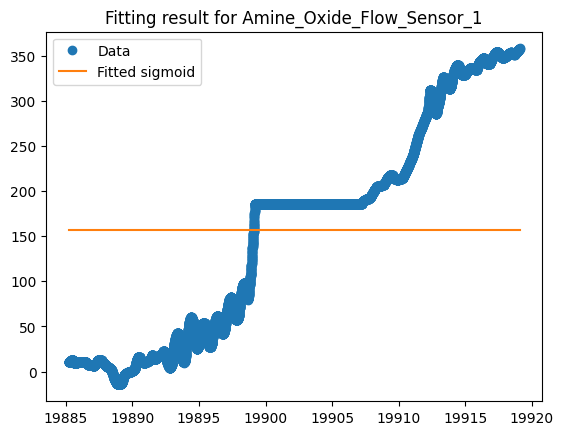

[np.float64(206.7352789266438), np.float64(17.005146073356187), 1000, np.float64(9959.534722222223)]
Optimized parameters for Amine_Oxide_Flow_Sensor_2: A=16445.059080704013, B=-16337.971743936134, k=1000.0, x0=9959.534722222223


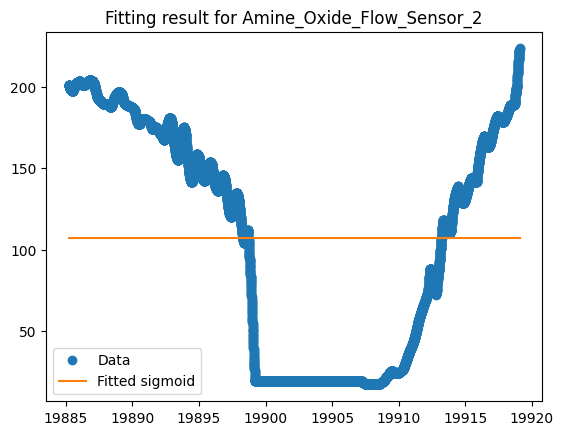

[np.float64(4.3595700282526995), np.float64(12.769947522251927), 1000, np.float64(9959.258680555557)]
Optimized parameters for Amine_Oxide_Flow_Temp_1: A=-7138.910611854769, B=7152.907931210803, k=1000.0, x0=9959.258680555557


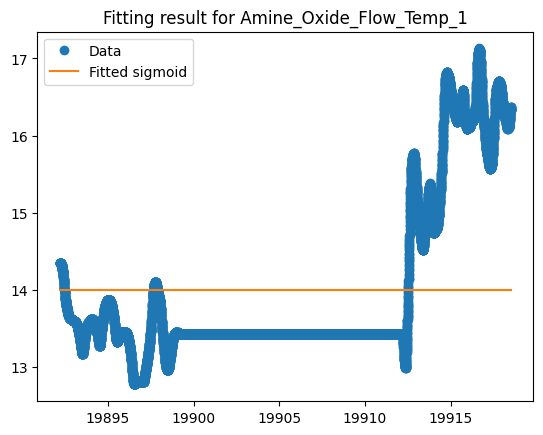

[np.float64(1.7448411778672153), np.float64(13.23242779027943), 1000, np.float64(9959.258680555557)]
Optimized parameters for Amine_Oxide_Flow_Temp_2: A=-250.4928282765868, B=264.75299449229715, k=1000.0, x0=9959.258680555557


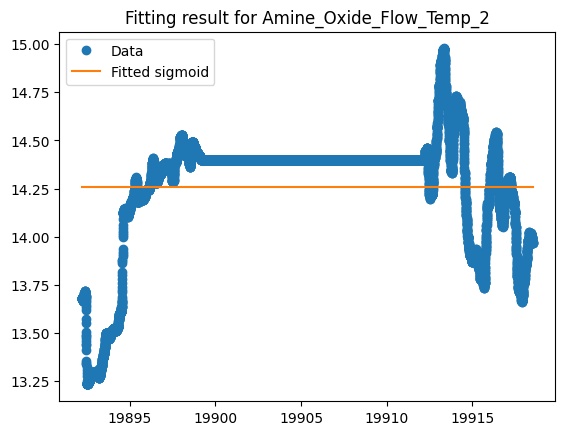

In [42]:
for header, data in headers.items():
    timestamp = data[0]
    time_objects = [io.parse_date(date_string=string) for string in timestamp]
    times = [io.convert_datetime(date_time=time) for time in time_objects]
    sensor = data[1]
    zipped_lists = zip(times, sensor)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    sensor_time, sensor_data = [list(tuple) for tuple in tuples]
    window_size = 800
    moving_average = np.convolve(sensor_data, np.ones(window_size), 'valid') / window_size
    time_hours = [t / 3600 for t in sensor_time]
    time_days = [t / 24 for t in time_hours]
    time = time_days[0: -(window_size-1)]
    time_space = np.linspace(min(time), max(time), 10000)
    data_space = np.interp(time_space, time, moving_average)

    try:
        A_opt, B_opt, k_opt, x0_opt = fit_sigmoid(x_data=time_space, y_data=data_space)
        print(f"Optimized parameters for {header}: A={A_opt}, B={B_opt}, k={k_opt}, x0={x0_opt}")
        
        # Plot the fitted sigmoid
        x_fit = np.linspace(min(time), max(time), 1000)
        y_fit = sigmoid(x_fit, A_opt, B_opt, k_opt, x0_opt)
        plt.plot(time_space, data_space, 'o', label='Data')
        plt.plot(x_fit, y_fit, '-', label='Fitted sigmoid')
        plt.legend()
        plt.title(f'Fitting result for {header}')
        plt.show()

    except RuntimeError as e:
        print(f'Error fitting sigmoid for {header}: {e}')